In [1]:
import os
import sys
from itertools import groupby, product
import urllib.request as request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
torch.cuda.set_device(0)

np.set_printoptions(suppress=True)

pd.set_option('display.max_columns',   10)
pd.set_option('display.max_rows',    1000)
pd.set_option('display.max_colwidth', 150)

SEED    = 420
np.random.seed(SEED)

AA      = 'AGILPVFWYDERHKSTCMNQ'

AA_FREQ = np.array(
          [0.08259085, 0.07077786, 0.05966563, 0.09670638, 0.04705176,
           0.06877565, 0.03864251, 0.01081189, 0.02923216, 0.05456002,
           0.06757433, 0.05536090, 0.02272500, 0.05846431, 0.06567224,
           0.05345880, 0.01371509, 0.02422665, 0.04064471, 0.03934328], dtype=float)


In [3]:
from sklearn.decomposition import PCA

def load_features():
    # load all datasets
    esm_pt  = 'data/transformer/representations_caax_pad100.pt'
    esm_fa  = 'data/transformer/caax_pad100.fa'
    esm_tsr = torch.load(esm_pt)[:,-5:,:] # cxxx sequence WITH terminal character
    esm_seq = np.array([i.strip()[-4:] for i in open(esm_fa) if not i.startswith('>')])
    
    df      = pd.read_csv('data/dataset_scaled.csv')
    df      = df.set_index('sequence').loc[esm_seq]
    
    assert all(df.index.values==esm_seq)
    
    # create individual datasets
    seq     = esm_seq
    prenyl  = df['prenyl'].values
    cleave  = df['cleave'].values    
    oh_lab  = np.array(list(filter(lambda x:x.startswith('OH:'), df.columns)), dtype=object)
    oh      = df[oh_lab].values#reset_index(drop=True)
    aai_lab = np.array(list(filter(lambda x:x.startswith('AAi:'), df.columns)), dtype=object)
    aai     = df[aai_lab].values#reset_index(drop=True)
    esm     = esm_tsr.reshape(esm_tsr.shape[0], esm_tsr.shape[1]*esm_tsr.shape[2])
    
    # shuffle
    shuffle = np.random.permutation(np.arange(8000))
    seq     = seq[shuffle]
    prenyl  = prenyl[shuffle]
    cleave  = cleave[shuffle]
    oh      = oh[shuffle]
    aai     = aai[shuffle]
    esm     = esm[shuffle]
    
    return seq, prenyl, cleave, oh, aai, esm

def load_validation(seq):
    val = pd.DataFrame(
        [['CIIS', 1, 1],
         ['CIKS', 0, 0],
         ['CIIL', 1, 1],
         ['CIDL', 0, 0],
         ['CVIM', 1, 1],
         ['CVKM', 1, 0],
         ['CSII', 1, 1],
         ['CSEI', 0, 0],
         ['CSNA', 1, 0],
         ['CYNA', 1, 0],
         ['CSGL', 0, 0],
         ['CSGK', 0, 0],
         ['CKQS', 1, 0],
         ['CFIF', 1, 0],
         ['CAPY', 1, 0],
         ['CTVA', 1, 1],
         ['CALD', 1, 0],
         ['CAVS', 1, 1],
         ['CIQF', 1, 0]],
        columns=['sequence','prenyl','cleave'])
    d = dict(i[::-1] for i in enumerate(seq))
    val_ind = [d[i] for i in val['sequence'].values]
    return val, val_ind

def decompose(oh, aai, esm, known):
    print('known: ',sum(known))
    var    = 0.99
    
    pca    = PCA(n_components=None, random_state=SEED).fit(oh[known])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    oh_pc  = pca.transform(oh)[:,:(cumsum<var).sum()]
    
    pca    = PCA(n_components=None, random_state=SEED).fit(aai[known])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    aai_pc = pca.transform(aai)[:,:(cumsum<var).sum()]
    
    pca    = PCA(n_components=None, random_state=SEED).fit(esm[known])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    esm_pc = pca.transform(esm)[:,:(cumsum<var).sum()]   
    
    return oh_pc, aai_pc, esm_pc

seq, prenyl, cleave, oh, aai, esm = load_features()
val, val_ind                      = load_validation(seq)
oh_pc, aai_pc, esm_pc             = decompose(oh, aai, esm, prenyl==prenyl)

best_models                       = {'motif':seq}

known:  997


# histograms

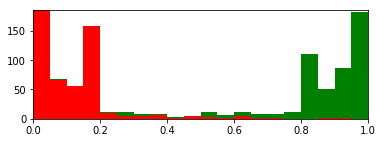

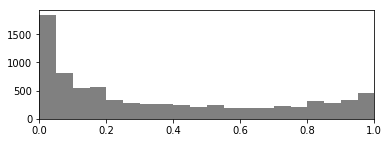

In [6]:
from sklearn.svm import SVC

def analysis(X, y, name='model', param={}):
    known = y == y
    
    # train
    model = SVC(random_state=SEED, **param)
    model.fit(X[known], y[known])
    
    # plot dist
    y_prob = model.predict_proba(X[known * (y==1)]).T[1]
    h1, e1 = np.histogram(y_prob, bins=20, range=(0,1))
    e1, w1 = (e1[1:]+e1[:-1])/2, e1[1]-e1[0]

    y_prob = model.predict_proba(X[known * (y==0)]).T[1]
    h2, e2 = np.histogram(y_prob, bins=20, range=(0,1))
    e2, w2 = (e2[1:]+e2[:-1])/2, e2[1]-e2[0]
    
    plt.close(); plt.figure(figsize=(6,2))
    plt.bar(e2, h2, width=w1, color='red')
    plt.bar(e1, h1, width=w1, bottom=h2, color='green')
    # plt.yticks([])
    plt.xlim(0,1)
    plt.show()
    
    y_prob = model.predict_proba(X).T[1]
    h, e   = np.histogram(y_prob, bins=20, range=(0,1))
    e, w   = (e[1:]+e[:-1])/2, e[1]-e[0]
    plt.close(); plt.figure(figsize=(6,2))
    plt.bar(e, h, width=w1, color='grey')
    # plt.yticks([])
    plt.xlim(0,1)
    plt.show()
    
    best_models['prenyl_svm_esm1b_prediction' ] = model.predict(X)
    best_models['prenyl_svm_esm1b_probability'] = np.round(model.predict_proba(X).T[1], decimals=6)
    
X      = esm_pc
y      = prenyl
param  = {'C': 20, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True} # PRE-TUNED PARAMETERS
analysis(X, y, name='prenyl', param=param)

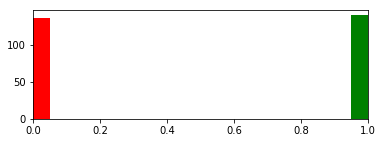

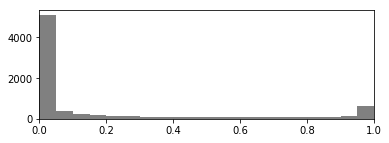

In [7]:
from sklearn.svm import SVC

def analysis(X, y, name='model', param={}):
    known = y == y
    
    # train
    model = SVC(random_state=SEED, **param)
    model.fit(X[known], y[known])
    
    # plot dist
    y_prob = model.predict_proba(X[known * (y==1)]).T[1]
    h1, e1 = np.histogram(y_prob, bins=20, range=(0,1))
    e1, w1 = (e1[1:]+e1[:-1])/2, e1[1]-e1[0]
    
    y_prob = model.predict_proba(X[known * (y==0)]).T[1]
    h2, e2 = np.histogram(y_prob, bins=20, range=(0,1))
    e2, w2 = (e2[1:]+e2[:-1])/2, e2[1]-e2[0]
    
    plt.close(); plt.figure(figsize=(6,2))
    plt.bar(e2, h2, width=w1, color='red')
    plt.bar(e1, h1, width=w1, bottom=h2, color='green')
    # plt.yticks([])
    plt.xlim(0,1)
    plt.show()
    
    y_prob = model.predict_proba(X).T[1]
    h, e   = np.histogram(y_prob, bins=20, range=(0,1))
    e, w   = (e[1:]+e[:-1])/2, e[1]-e[0]
    plt.close(); plt.figure(figsize=(6,2))
    plt.bar(e, h, width=w1, color='grey')
    # plt.yticks([])
    plt.xlim(0,1)
    plt.show()
    
    best_models['cleave_svm_esm1b_prediction' ] = model.predict(X)
    best_models['cleave_svm_esm1b_probability'] = np.round(model.predict_proba(X).T[1], decimals=6)

X   = esm_pc
y   = cleave
param  = {'C': 30, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True} # PRE-TUNED PARAMETERS
analysis(X, y, name='cleave', param=param)

# combined

In [8]:
def analysis():
    df = pd.DataFrame(best_models)
    x = df[['prenyl_svm_esm1b_prediction','cleave_svm_esm1b_prediction']]
    df['prediction'] = [(('cleaved' if c else 'shunted') if p else 'non-prenylated') for p, c in x.values.astype(bool)]
    x = [tuple(i) for i in x.values.astype(int)]
    x = [(k, sum(1 for i in g)) for k, g in groupby(sorted(x))]
    for (a, b), i in x:
        print('prenyl:%s  cleave:%s' % (a, b))
        print(i)
        print()
    
    df = df.sort_values('motif')
    df.to_csv('results/combined_prediction.csv', index=None)    
    
    return df

analysis()

prenyl:0  cleave:0
4975

prenyl:0  cleave:1
389

prenyl:1  cleave:0
1420

prenyl:1  cleave:1
1216



,motif,prenyl_svm_esm1b_prediction,prenyl_svm_esm1b_probability,cleave_svm_esm1b_prediction,cleave_svm_esm1b_probability,prediction
4839,CAAA,1.0,0.807656,0.0,0.003043,shunted
4126,CAAC,1.0,0.568503,0.0,0.142021,shunted
3011,CAAD,0.0,0.420915,0.0,0.000062,non-prenylated
608,CAAE,0.0,0.241172,0.0,0.000062,non-prenylated
5929,CAAF,1.0,0.699024,0.0,0.162005,shunted
6846,CAAG,1.0,0.729905,0.0,0.000186,shunted
3402,CAAH,1.0,0.967943,0.0,0.000359,shunted
562,CAAI,1.0,0.842039,0.0,0.005790,shunted
867,CAAK,0.0,0.015702,0.0,0.000501,non-prenylated
2506,CAAL,0.0,0.321467,0.0,0.002626,non-prenylated
